# 📘 Advanced Features: Callbacks, Robust Fitting, Auto Initial Guess⏱️ **30-40 minutes** | 📊 **Level: ●●○ Intermediate** | 🏷️ **Advanced**---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/imewei/NLSQ/blob/main/examples/notebooks/02_core_tutorials/advanced_features_demo.ipynb)


In [1]:
# @title Install NLSQ (run once in Colab)
import sys

if 'google.colab' in sys.modules:
    print("Running in Google Colab - installing NLSQ...")
    !pip install -q nlsq
    print("✅ NLSQ installed successfully!")
else:
    print("Not running in Colab - assuming NLSQ is already installed")

Not running in Colab - assuming NLSQ is already installed


## 🎯 What You'll Learn- ✓ **Monitor** optimization progress with callbacks- ✓ **Handle outliers** with robust loss functions- ✓ **Auto-generate** initial parameter guesses- ✓ **Customize** optimization algorithms- ✓ **Diagnose** convergence issues---

## Setup

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

In [3]:
from IPython.display import display

In [4]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from nlsq import CurveFit, auto_select_algorithm, callbacks

np.random.seed(42)

## 1. Progress Monitoring with Callbacks**Use case:** Track optimization progress in real-time

In [5]:
from nlsq.callbacks import ProgressBar


# Define model
def exponential(x, a, b, c):
    return a * jnp.exp(-b * x) + c

# Generate data
x = np.linspace(0, 10, 100)
y = 5 * np.exp(-0.5 * x) + 2 + np.random.normal(0, 0.2, 100)

# Create callback
progress = ProgressBar(desc="Fitting exponential")

# Fit with callback
jcf = CurveFit()
popt, pcov = jcf.curve_fit(
    exponential, x, y,
    p0=[4, 0.4, 1.5],
    callback=progress
)

print(f"\nFitted parameters: {popt}")

/home/wei/Documents/GitHub/NLSQ/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:nlsq.curve_fit:Starting curve fit n_params=3 | n_data_points=100 | method=trf | solver=auto | batch_size=None | has_bounds=False | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


INFO:nlsq.optimizer.trf:Starting TRF optimization (no bounds) n_params=3 | n_residuals=100 | max_nfev=None


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=0 | cost=17.407750850906602 | grad_norm=101.6770 | nfev=1


Fitting exponential: 0it [00:00, ?it/s]

Fitting exponential: 0it [00:00, ?it/s, cost=1.641811e+00, grad=1.017e+02, iter=1]

PERFORMANCE:nlsq.optimizer.trf:Iteration iter=1 | cost=1.6418109289583571 | grad_norm=2.0676 | step=4.290687590584987 | nfev=2


Fitting exponential: 1it [00:00, 16.96it/s, cost=1.549768e+00, grad=2.068e+00, iter=2]

PERFORMANCE:nlsq.optimizer.trf:Iteration iter=2 | cost=1.5497680125256106 | grad_norm=0.1594 | step=4.290687590584987 | nfev=3


Fitting exponential: 2it [00:00, 28.71it/s, cost=1.549732e+00, grad=1.594e-01, iter=3]

PERFORMANCE:nlsq.optimizer.trf:Iteration iter=3 | cost=1.5497315198950572 | grad_norm=3.5230e-04 | step=4.290687590584987 | nfev=4


Fitting exponential: 3it [00:00, 39.66it/s, cost=1.549732e+00, grad=3.523e-04, iter=4]

PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.232067s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=4 | final_cost=1.5497 | elapsed=1.232s | final_gradient_norm=7.9698e-06


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=1.994291s


INFO:nlsq.curve_fit:Curve fit completed total_time=1.9943 | final_cost=3.0995 | covariance_warning=False



Fitted parameters: [5.1017183  0.53903947 2.02937336]


## 2. Robust Fitting (Outlier Rejection)**Problem:** Outliers distort least-squares fits**Solution:** Use robust loss functions

INFO:nlsq.curve_fit:Starting curve fit n_params=3 | n_data_points=100 | method=trf | solver=auto | batch_size=None | has_bounds=False | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


INFO:nlsq.optimizer.trf:Starting TRF optimization (no bounds) n_params=3 | n_residuals=100 | max_nfev=None


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=0 | cost=63.69195973109045 | grad_norm=132.3051 | nfev=1


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=1 | cost=33.424178460099455 | grad_norm=12.3218 | step=4.290687590584987 | nfev=2


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=2 | cost=32.146782424662234 | grad_norm=0.1250 | step=4.290687590584987 | nfev=3


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=3 | cost=32.146487001672895 | grad_norm=0.0271 | step=4.290687590584987 | nfev=4


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=4 | cost=32.146481497240494 | grad_norm=0.0047 | step=4.290687590584987 | nfev=5


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.037758s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=5 | final_cost=32.1465 | elapsed=0.038s | final_gradient_norm=8.1916e-04


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.120332s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.1203 | final_cost=64.2930 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=3 | n_data_points=100 | method=trf | solver=auto | batch_size=None | has_bounds=False | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=huber | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


INFO:nlsq.optimizer.trf:Starting TRF optimization (no bounds) n_params=3 | n_residuals=100 | max_nfev=None


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=0 | cost=34.410125415910336 | grad_norm=106.3871 | nfev=1


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=1 | cost=17.124221344255705 | grad_norm=8.8224 | step=2.145343795292493 | nfev=3


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=2 | cost=16.677055727810647 | grad_norm=0.6757 | step=2.145343795292493 | nfev=4


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=3 | cost=16.673836804276387 | grad_norm=0.0350 | step=2.145343795292493 | nfev=5


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=4 | cost=16.673828364526138 | grad_norm=0.0031 | step=2.145343795292493 | nfev=6


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.445733s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=5 | final_cost=16.6738 | elapsed=0.446s | final_gradient_norm=2.7489e-04


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.831694s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.8317 | final_cost=33.3477 | covariance_warning=False


Standard fit (affected by outliers):
  Parameters: [5.73882515 0.70698901 2.34674902]

Robust fit (resistant to outliers):
  Parameters: [5.28913937 0.58925377 2.13992003]


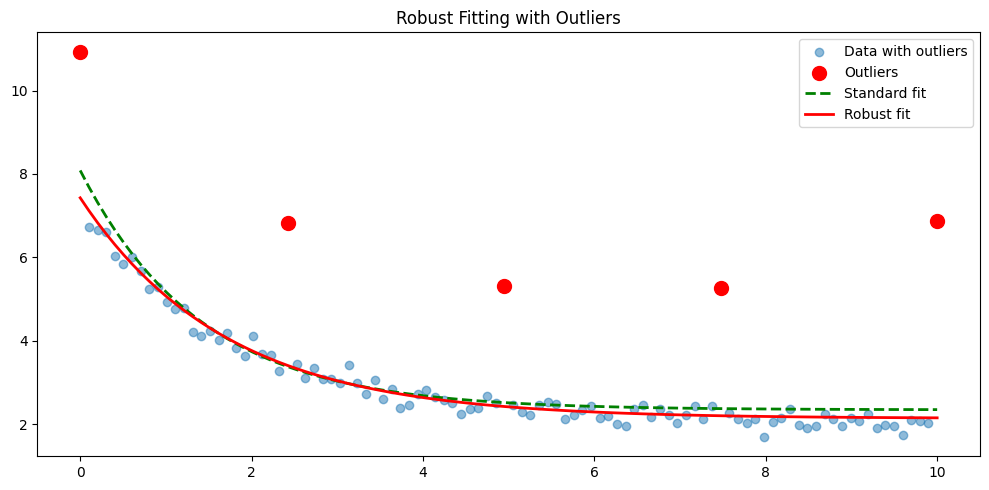

In [6]:
# Generate data with outliers
y_outliers = y.copy()
outlier_idx = np.linspace(0, len(x) - 1, num=min(5, len(x)), dtype=int)
outlier_idx = np.unique(outlier_idx)
y_outliers[outlier_idx] += np.random.uniform(3, 5, len(outlier_idx))

# Standard fit (affected by outliers)
popt_std, _ = jcf.curve_fit(exponential, x, y_outliers, p0=[4, 0.4, 1.5])

# Robust fit
popt_robust, _ = jcf.curve_fit(
    exponential, x, y_outliers,
    p0=[4, 0.4, 1.5],
    loss='huber'  # Robust loss function
)

print("Standard fit (affected by outliers):")
print(f"  Parameters: {popt_std}")
print("\nRobust fit (resistant to outliers):")
print(f"  Parameters: {popt_robust}")

# Visualize
fig = plt.figure(figsize=(10, 5))
plt.scatter(x, y_outliers, alpha=0.5, label='Data with outliers')
plt.scatter(x[outlier_idx], y_outliers[outlier_idx], c='red', s=100, label='Outliers')
plt.plot(x, exponential(x, *popt_std), 'g--', label='Standard fit', linewidth=2)
plt.plot(x, exponential(x, *popt_robust), 'r-', label='Robust fit', linewidth=2)
plt.legend()
plt.title('Robust Fitting with Outliers')
plt.tight_layout()
plt.show()

## 3. Automatic Initial Guess**Feature:** NLSQ can estimate initial parameters automatically

In [7]:
# Fit without providing p0 (auto-guess)try:    popt_auto, _ = jcf.curve_fit(exponential, x, y)    print("Auto-generated initial guess successful!")    print(f"Fitted parameters: {popt_auto}")except Exception as e:    print(f"Auto-guess failed: {e}")    print("Tip: Provide p0 for complex models")

## 4. Algorithm Selection**NLSQ features:** Automatic algorithm selection based on problem characteristics

In [8]:
# Auto-select algorithmrecommendations = auto_select_algorithm(exponential, x, y)print("Algorithm Recommendations:")print(f"  Algorithm: {recommendations['algorithm']}")print(f"  Tolerance: {recommendations['ftol']}")print(f"  Complexity: {recommendations.get('complexity', 'Standard')}")# Use recommended settingspopt_opt, _ = jcf.curve_fit(    exponential, x, y,    p0=[4, 0.4, 1.5],    ftol=recommendations['ftol'])print(f"\nOptimized fit: {popt_opt}")

## 🔑 Key Takeaways1. **Callbacks** enable real-time monitoring2. **Robust loss** handles outliers gracefully3. **Auto p0** simplifies fitting4. **Algorithm selection** optimizes convergence5. **Customization** gives fine control---

## 🔗 Next Steps- [Performance Optimization](performance_optimization_demo.ipynb) - Speed up fits- [Custom Algorithms](../03_advanced/custom_algorithms_advanced.ipynb) - Implement your own- [Troubleshooting Guide](../03_advanced/troubleshooting_guide.ipynb) - Diagnose issues---